# Training Kalman Filter for Results

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.training import *
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import *
from meteo_imp.gaussian import *

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *
from fastcore.foundation import L
from fastcore.foundation import patch
from pathlib import Path, PosixPath

from meteo_imp.kalman.training import show_results
import pandas as pd
import numpy as np
import torch
import random
from pyprojroot import here

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from IPython.display import Image, HTML

from tqdm.auto import tqdm

In [ ]:
from fastcore.basics import *

In [ ]:
show_metrics = False

In [ ]:
reset_seed()

In [ ]:
hai = pd.read_parquet(hai_big_path)
hai_era = pd.read_parquet(hai_era_big_path)

In [ ]:
base = here("analysis/results/trained_models")

In [ ]:
base.mkdir(exist_ok=True)

In [ ]:
@patch
def add_end(self: PosixPath, end): return self.parent / (self.name + end)

In [ ]:
def train_or_load(model, dls, lr, n, path, keep=True):
    save_models = SaveModelsBatch(times_epoch=5)
    csv_logger = CSVLogger(path.add_end("log.csv"))
    learn = Learner(dls, model, KalmanLoss(only_gap=True), cbs = [Float64Callback, save_models, csv_logger], metrics=rmse_gap) 
    items = random.choices(dls.valid.items, k=4) 
    if path.add_end(".pickle").exists() and keep:
        learn.model = torch.load(path.add_end(".pickle"))
        display(csv_logger.read_log())
        plot = Image(filename=path.add_end("_loss_plot.png"))
        display(plot)
    else:
        learn.fit(lr, n)
        
        torch.save(learn.model, path.add_end(".pickle"))
        learn.recorder.plot_loss()
        plt.savefig(path.add_end("_loss_plot.png"))
    return learn, items                           

In [ ]:
def metric_valid(learn, dls=None):
    nrmse = []
    losses = []
    dls = ifnone(dls, learn.dls.valid)
    for input, target in tqdm(dls, leave=False):
        pred = learn.model(input)
        nrmse.append(learn.metrics[0](pred, target))
        losses.append(learn.loss_func(pred, target).item())
    metric = pd.DataFrame({'loss': losses, 'rmse': nrmse})
    return metric.agg(['mean', 'std'])

In [ ]:
hai.columns

Index(['TA', 'SW_IN', 'LW_IN', 'VPD', 'WS', 'PA', 'P', 'SWC', 'TS'], dtype='object')

## Generic model | gap len 3-336 | gap 1 random 

In [ ]:
dls_A1v = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = gen_var_sel(list(hai.columns), n_var=1),
    block_len=100+336,
    gap_len=gen_gap_len(6, 336),
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=5).cpu()

In [ ]:
len(hai)

227952

In [ ]:
len(dls_A1v.train)*20, len(dls_A1v.valid)*20

(2080, 520)

In [ ]:
model_A1v = KalmanFilterSR.init_local_slope_pca(
    n_dim_obs= len(hai.columns),
    n_dim_state=len(hai.columns),
    n_dim_contr = len(hai_era.columns),
    df_pca = None, 
    pred_only_gap=True)

In [ ]:
model_A1v.B.shape

torch.Size([1, 18, 14])

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,196.765350,163.493486,0.579074,48:33
1,1,138.298704,123.299909,0.490741,48:14
2,2,113.640141,116.746793,0.488059,39:00


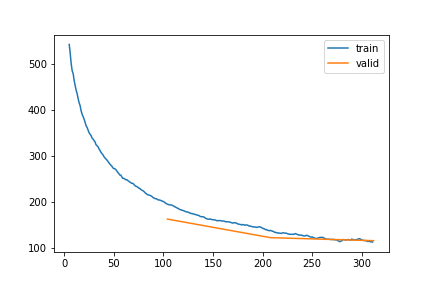

In [ ]:
learn_A1v, items_A1v = train_or_load(model_A1v, dls_A1v, 3, 1e-3, base / "1_gap_varying_6-336_v1")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,94.869328,112.046392,0.471249,43:59


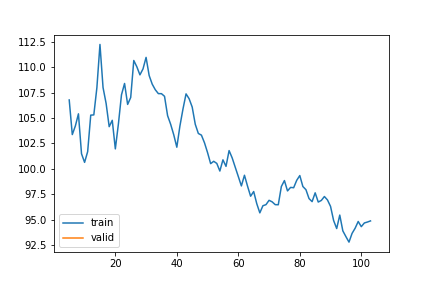

In [ ]:
learn_A1v, items_A1v = train_or_load(model_A1v, dls_A1v, 1, 1e-4, base / "1_gap_varying_6-336_v2")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,95.239438,104.268073,0.467282,40:19


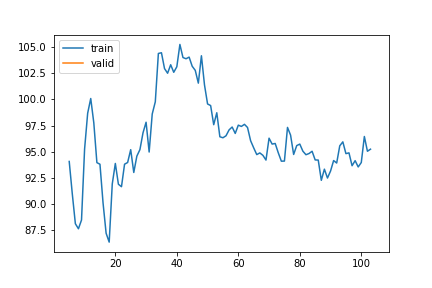

In [ ]:
learn_A1v, items_A1v = train_or_load(model_A1v, dls_A1v, 1, 1e-6, base / "1_gap_varying_6-336_v3")

## 1 var gap - varying 336 - No Control

In [ ]:
model_A1v_nc = KalmanFilterSR.init_local_slope_pca(
    n_dim_obs= len(hai.columns),
    n_dim_state=len(hai.columns),
    n_dim_contr = len(hai_era.columns),
    df_pca=None,
    pred_only_gap=True,
    use_control=False
)

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,219.686355,178.506325,0.658579,37:14
1,1,176.039201,160.979378,0.583213,37:00
2,2,166.012525,158.206468,0.574111,36:47


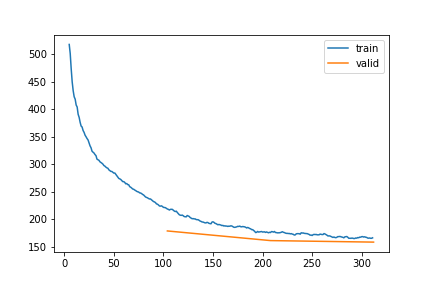

In [ ]:
learn_A1v_nc, items_A1v_nc = train_or_load(model_A1v_nc, dls_A1v, 3, 1e-3, base / "1_gap_varying_336_no_control_v1")

## Short gaps

### All variables - 30 all

In [ ]:
dls_Aa = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = list(hai.columns),
    block_len=120,
    gap_len=gen_gap_len(6, 30),
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=5
).cpu()

In [ ]:
dls_Aa = imp_dataloader(hai, hai_era, var_sel = list(hai.columns), block_len=120, gap_len=gen_gap_len(6,30), bs=20, control_lags=[1], n_rep=10).cpu()

In [ ]:
model_Aa = learn_A1v.model.copy()

In [ ]:
if show_metrics: display(metric_valid(learn_A1v, dls=dls_Aa.valid))

In [ ]:
dls_A1v30 = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = gen_var_sel(list(hai.columns), n_var=1),
    block_len=100+30,
    gap_len=gen_gap_len(6, 30),
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=5).cpu()

In [ ]:
if show_metrics: display(metric_valid(learn_A1v, dls=dls_A1v30.valid))

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,24.688308,21.049544,0.365108,28:05
1,1,-7.512621,-4.152000,0.342344,27:26
2,2,-18.230698,-19.744404,0.327594,26:15


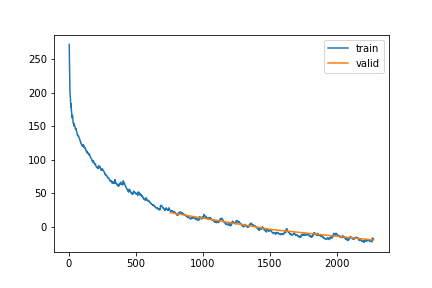

In [ ]:
learn_Aa, items_Aa = train_or_load(model_Aa, dls_Aa, 3, 3e-4, base / "All_gap_all_30_v1")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,4.763339,3.134267,0.276432,15:02
1,1,2.390429,1.721823,0.267772,16:12
2,2,0.780169,0.607745,0.255524,16:05


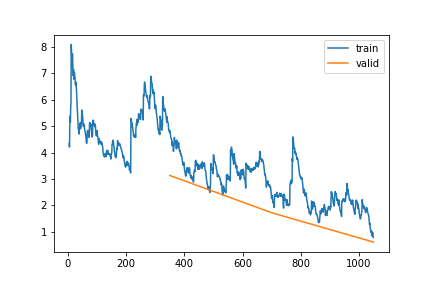

In [ ]:
learn_A1v30, items_A1v30 = train_or_load(learn_A1v.model.copy(), dls_A1v30, 3, 3e-4, base / "1_gap_varying_tuned_6-30_v1")

so this is not working ...

### Varying number of variables missing | short gaps 6-30

In [ ]:
dls_Vv30 = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = gen_var_sel(list(hai.columns)),
    block_len=100+30,
    gap_len=gen_gap_len(6, 30),
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=20).cpu()

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-5.794561,-4.508800,0.213908,1:00:55
1,1,-3.717697,-5.165062,0.205841,1:00:26
2,2,-1.928287,-6.012112,0.202048,1:00:21


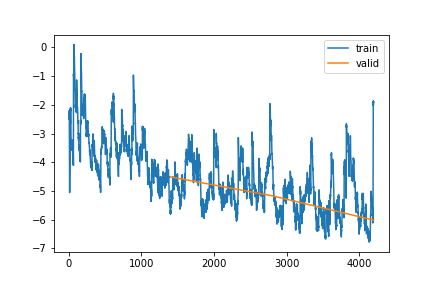

In [ ]:
learn_Vv30, items_Vv30 = train_or_load(learn_Aa.model, dls_Vv30, 3, 5e-4, base / "all_varying_gap_varying_len_6-30_v1")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-7.061014,-6.663726,0.192194,57:55


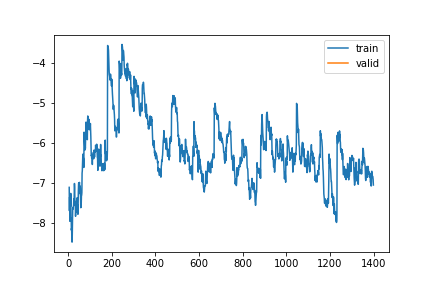

In [ ]:
learn_Vv30, items_Vv30 = train_or_load(learn_Aa.model, dls_Vv30, 1, 1e-5, base / "all_varying_gap_varying_len_6-30_v2")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-7.417934,-6.799482,0.19076,1:00:23


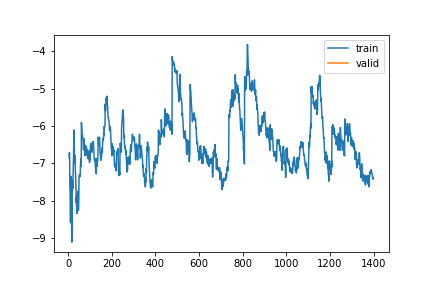

In [ ]:
learn_Vv30, items_Vv30 = train_or_load(learn_Aa.model, dls_Vv30, 1, 1e-5, base / "all_varying_gap_varying_len_6-30_v3")

### Random parameters

In [ ]:
model_Vv_rand = KalmanFilterSR.init_random(
    n_dim_obs= len(hai.columns),
    n_dim_state=2*len(hai.columns),
    n_dim_contr = 2*len(hai_era.columns),
    seed=27,
    pred_only_gap=True)

epoch,train_loss,valid_loss,rmse_gap,time
0,13.508053,14.374478,0.448185,1:00:35
1,9.766153,11.389963,0.395332,58:51
2,6.503961,6.754238,0.305433,54:16


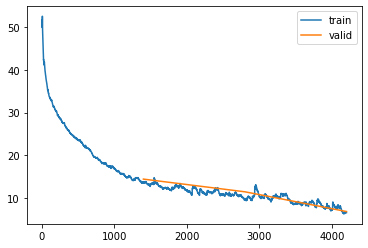

In [ ]:
learn_Vv_rand, items_Vv_rand = train_or_load(model_Vv_rand, dls_Vv30, 3, 1e-3, base / "rand_all_varying_gap_varying_len_6-30_v1")

epoch,train_loss,valid_loss,rmse_gap,time
0,5.101230,5.345336,0.285398,1:02:15
1,4.838514,4.907970,0.281667,1:02:44
2,4.571287,4.295109,0.275344,1:04:47


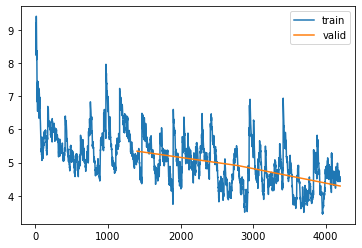

In [ ]:
learn_Vv_rand, items_Vv_rand = train_or_load(learn_Vv_rand.model, dls_Vv30, 3, 1e-4, base / "rand_all_varying_gap_varying_len_6-30_v2")

epoch,train_loss,valid_loss,rmse_gap,time
0,4.075190,4.282635,0.275272,2:36:25
1,5.134852,4.244826,0.274858,1:17:58
2,3.923739,4.185355,0.274057,1:11:31


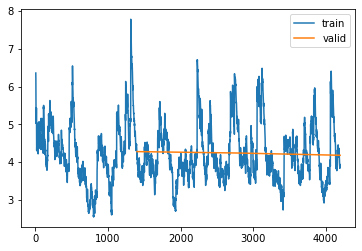

In [ ]:
learn_Vv_rand, items_Vv_rand = train_or_load(learn_Vv_rand.model, dls_Vv30, 3, 1e-5, base / "rand_all_varying_gap_varying_len_6-30_v3")

epoch,train_loss,valid_loss,rmse_gap,time
0,4.100049,4.142156,0.273928,56:48
1,3.712223,4.112651,0.273566,56:59
2,3.942678,4.073334,0.273349,57:03


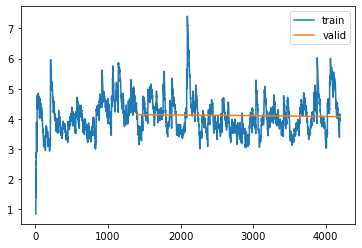

In [ ]:
learn_Vv_rand, items_Vv_rand = train_or_load(learn_Vv_rand.model, dls_Vv30, 3, 1e-5, base / "rand_all_varying_gap_varying_len_6-30_v4")

In [ ]:
model_Vv_rand

state,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17
x_0,0.8775,0.2675,0.0937,0.6706,0.1638,0.9272,0.2620,0.4967,0.2630,0.1175,0.1694,0.2100,0.4890,0.0564,0.4760,0.7606,0.7759,0.5243
x_1,0.3714,0.0426,0.2343,0.9991,0.1775,0.6319,0.6734,0.7937,0.6468,0.5825,0.4599,0.7960,0.9038,0.9735,0.6428,0.3725,0.2052,0.0507
x_2,0.4448,0.5775,0.7237,0.5927,0.3217,0.6441,0.2801,0.9132,0.0329,0.4856,0.9927,0.5895,0.2611,0.9413,0.1371,0.8726,0.5590,0.8451
x_3,0.1253,0.9434,0.0462,0.2360,0.0239,0.8950,0.7419,0.9471,0.6690,0.1554,0.0821,0.7309,0.7764,0.9769,0.0196,0.0384,0.4294,0.3438
x_4,0.5494,0.8238,0.9845,0.6826,0.9001,0.3022,0.7509,0.0926,0.0328,0.4798,0.5335,0.0434,0.3530,0.4157,0.7495,0.1716,0.1980,0.4298
x_5,0.9201,0.6883,0.5342,0.7847,0.3137,0.1778,0.5838,0.9799,0.3611,0.3155,0.7475,0.5450,0.5641,0.2493,0.8323,0.9723,0.1883,0.3605
x_6,0.5344,0.3443,0.7696,0.3410,0.7553,0.3177,0.0315,0.5209,0.6514,0.3131,0.4510,0.3550,0.4790,0.0676,0.3606,0.7299,0.6713,0.3134
x_7,0.7460,0.1291,0.4653,0.5693,0.9906,0.8288,0.9039,0.5240,0.6277,0.3574,0.0076,0.6530,0.8667,0.9368,0.8667,0.6749,0.3526,0.6618
x_8,0.0837,0.7188,0.7247,0.3211,0.4898,0.9030,0.0358,0.1662,0.7741,0.7937,0.7183,0.5141,0.4918,0.2773,0.6901,0.8565,0.3723,0.3410
x_9,0.4035,0.0591,0.6836,0.8306,0.4312,0.0210,0.0032,0.9010,0.6741,0.3875,0.3683,0.5337,0.0706,0.8516,0.7304,0.8507,0.6829,0.6900


## Fine tuning

### Fine tune Variable | gap only for one variable | gap len 6-336

fine tune the model to only one variable

In [ ]:
from fastcore.basics import *

In [ ]:
from IPython.display import HTML

In [ ]:
var_learning = {
    'TA': [{'lr': 1e-3, 'n': 3}],  
    'SW_IN': [{'lr': 1e-3, 'n': 4}],  
    'SW_IN': [{'lr': 1e-3, 'n': 4}],  
    'LW_IN': [{'lr': 1e-3, 'n': 3}],  
    'VPD': [{'lr': 1e-3, 'n': 3}],  
    'WS': [{'lr': 1e-3, 'n': 3}],  
    'PA': [{'lr': 1e-3, 'n': 3}],  
    # 'P': [{'lr': 1e-3, 'n': 3}], missing on purpose  
    'SWC' : [{'lr': 1e-3, 'n': 5}, {'lr': 1e-5, 'n': 1}],
    'TS' : [{'lr': 1e-3, 'n': 5}],


}

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (__class__) that exists in the learner. Use `self.learn.__class__` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


In [ ]:
def fine_tune(var_learning, learn):
    spec_models = {}
    spec_dls = {}
    spec_learn = {}
    spec_items = {}
    for var in tqdm(var_learning.keys()):
        display(HTML(f"<h4> {var} | Gap len 6-336  finetune</h4>"))
        spec_dls[var] = imp_dataloader(hai, hai_era, var_sel = var, block_len=100+336, gap_len=gen_gap_len(6, 336), bs=20, control_lags=[1], n_rep=3, shifts=gen_shifts(50)).cpu()
        if show_metrics:
            display(HTML("Metrics generic model"))
            display(metric_valid(learn, dls=spec_dls[var].valid))
        for i, train in enumerate(var_learning[var]):
            lr, n = train
            display(HTML(f"train {i}"))
            spec_models[var] = learn.model.copy()
            spec_learn[var], spec_items[var] = train_or_load(spec_models[var], spec_dls[var], lr, n, base / f"{var}_specialized_gap_6-336_v1_{i}")
            plt.show()
    return spec_models, spec_dls, spec_learn, spec_items

  0%|          | 0/8 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-73.308072,-59.729135,0.155103,23:04
1,1,-87.049737,-73.262853,0.139768,20:37
2,2,-92.947376,-82.557740,0.131374,21:16


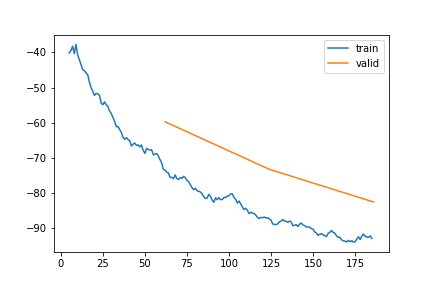

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,53.445060,43.464660,0.286705,23:25
1,1,49.458273,42.814378,0.285042,23:47
2,2,48.186476,43.087234,0.283170,22:43


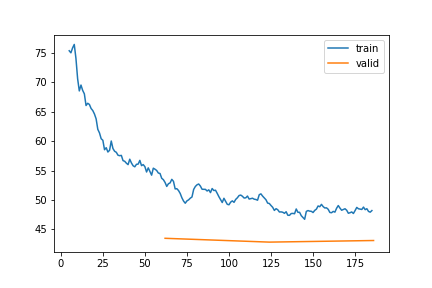

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,104.665918,106.041969,0.414556,22:34
1,1,101.284686,107.526856,0.419593,23:28
2,2,99.767878,108.885340,0.420613,23:43


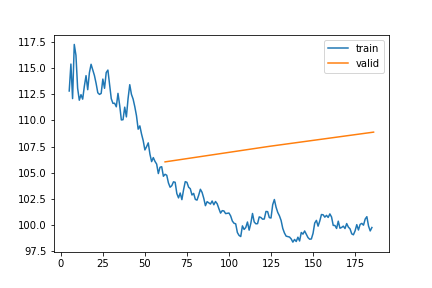

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,52.165032,50.852617,0.295505,23:31
1,1,45.131744,36.635116,0.272213,22:41
2,2,41.990330,32.914802,0.264974,23:06


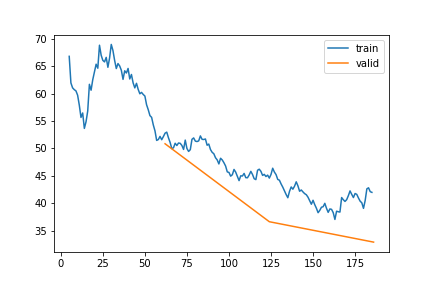

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,175.891940,246.176982,0.761467,22:58
1,1,165.224262,235.823659,0.719208,23:03
2,2,159.586716,246.720599,0.727202,21:00


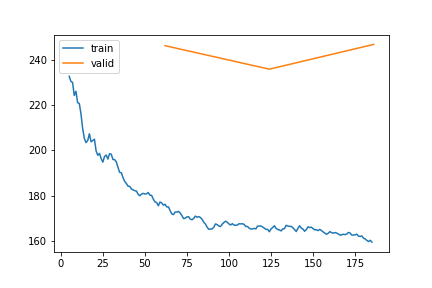

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-99.014311,-97.738537,0.127062,21:53
1,1,-123.031773,-104.182228,0.120468,22:45
2,2,-130.901483,-133.160406,0.104076,24:11


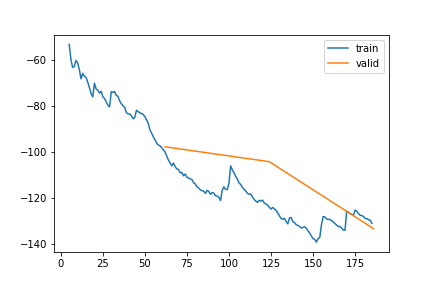

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,172.303569,200.127139,0.599423,23:57
1,1,132.754943,76.512459,0.305065,22:01
2,2,93.005439,57.391193,0.270830,20:58


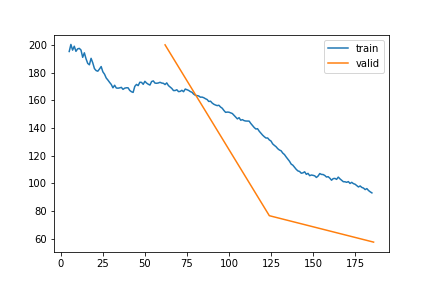

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,172.303569,200.127139,0.599423,23:57
1,1,132.754943,76.512459,0.305065,22:01
2,2,93.005439,57.391193,0.270830,20:58


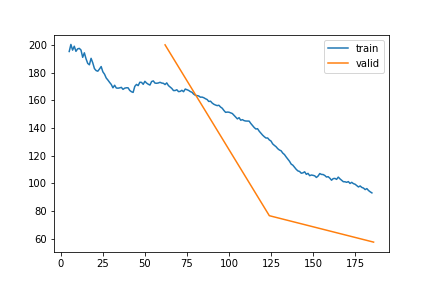

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,68.246805,54.157492,0.268725,23:05
1,1,57.107431,39.662085,0.247396,21:34
2,2,57.394308,53.605346,0.260903,20:52


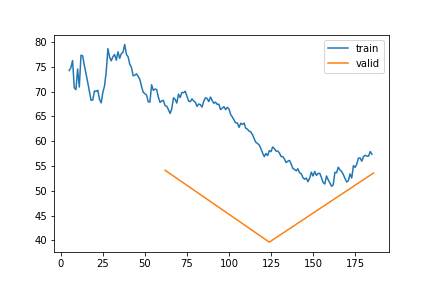

In [ ]:
spec_models, spec_dls, spec_learn, spec_items = fine_tune(var_learning, learn_A1v)

In [ ]:
var_learning2 = {
    'TA': [{'lr': 1e-3, 'n': 3}],  
    'VPD': [{'lr': 1e-3, 'n': 2}],  
    'PA': [{'lr': 1e-3, 'n': 2}],  
    'SWC' : [{'lr': 1e-3, 'n': 3}, {'lr': 1e-5, 'n': 1}],
    'TS' : [{'lr': 1e-3, 'n': 2}],
}

In [ ]:
def fine_tune2(var_learning, spec_dls, spec_learn, spec_items):
    spec_learn = spec_learn.copy()
    for var in tqdm(var_learning.keys()):
        display(HTML(f"<h4> {var} | Gap len 6-336  finetune 2 </h4>"))
        for i, train in enumerate(var_learning[var]):
            lr, n = train['lr'], train['n']
            v = train.get('v', 2)
            display(HTML(f"train {i}"))
            spec_learn[var], _ = train_or_load(spec_learn[var].model, spec_dls[var], n, lr, path=base / f"{var}_specialized_gap_6-336_v{v}_{i}")
            plt.show()
    return spec_dls, spec_learn, spec_items

  0%|          | 0/8 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-97.718002,-90.171141,0.125761,21:44
1,1,-100.493585,-88.338616,0.126856,20:23
2,2,-103.769092,-73.432097,0.135440,20:41


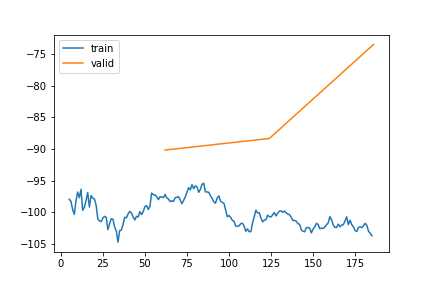

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,45.373127,42.291928,0.282366,20:34
1,1,46.487908,41.780965,0.283791,20:26
2,2,46.903155,45.729009,0.290985,20:43
3,3,46.917554,39.832071,0.278899,20:29


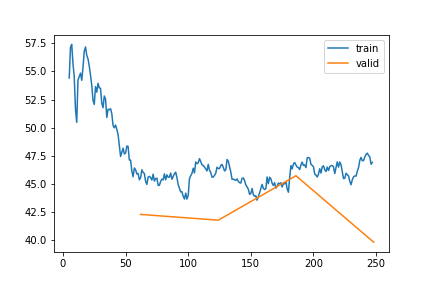

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,98.188426,107.646729,0.414824,20:22
1,1,95.761911,108.694974,0.416340,20:30
2,2,97.285924,106.717304,0.415862,20:30


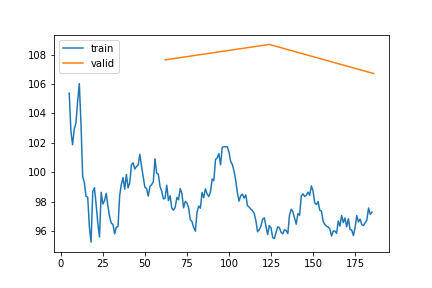

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,42.370522,31.185345,0.254092,20:27
1,1,37.933048,29.823322,0.255506,20:25
2,2,35.904875,25.101849,0.245977,20:28


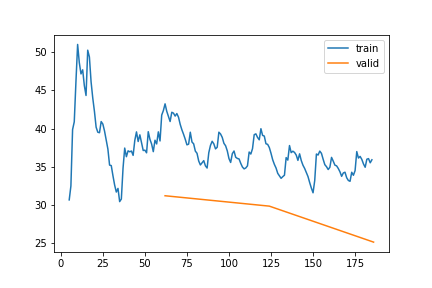

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,158.971839,247.131486,0.730278,20:37
1,1,158.584698,253.701959,0.736434,20:34
2,2,156.970299,263.529629,0.749744,20:22


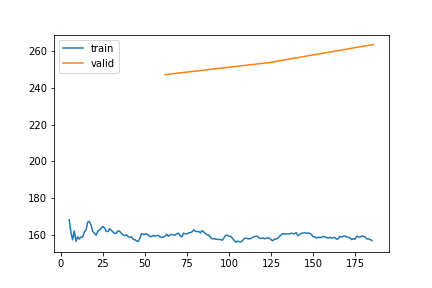

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-131.680055,-112.508634,0.115626,23:56
1,1,-145.849450,-95.348580,0.114896,24:38
2,2,-145.281960,-107.879192,0.116886,24:47


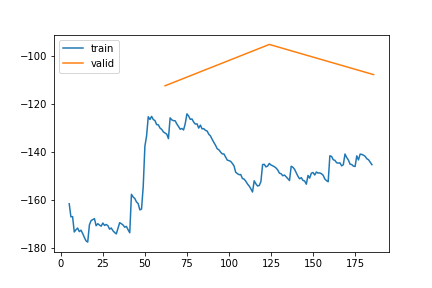

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,35.588624,-20.680066,0.174256,24:56
1,1,10.683595,-23.630941,0.167582,24:32
2,2,-34.885516,-76.834793,0.124991,25:11
3,3,-47.704883,0.936394,0.166095,24:47
4,4,-61.871826,-75.499625,0.120001,24:45


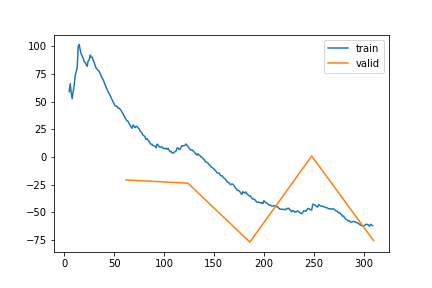

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-82.762576,-101.858651,0.103941,24:41


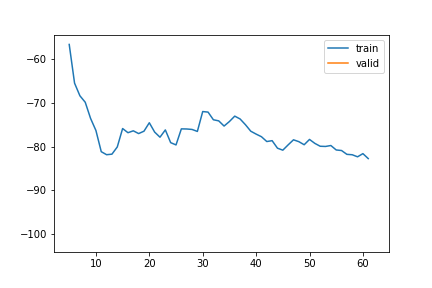

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,40.478151,29.605951,0.230160,25:47
1,1,36.143091,21.822619,0.211396,28:18
2,2,30.493916,-0.701642,0.181059,24:59
3,3,26.646244,17.138843,0.201734,27:48
4,4,19.231903,10.231487,0.202251,29:09


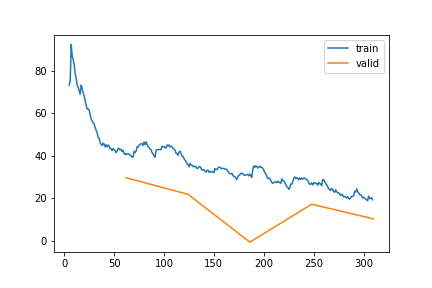

In [ ]:
spec_dls2, spec_learn2, spec_items2 = fine_tune2(var_learning2, spec_dls, spec_learn, spec_items)

In [ ]:
var_learning3 = {
    'TA': [{'lr': 1e-5, 'n': 1, 'v': 3}],  
    'PA': [{'lr': 1e-5, 'n': 1, 'v': 3}],  
}

  0%|          | 0/2 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,rmse_gap,time
0,-98.172894,-86.769272,0.131181,28:21


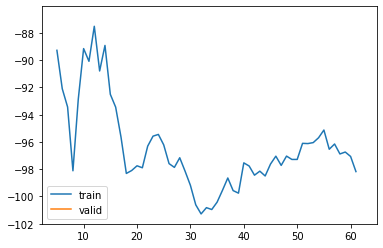

epoch,train_loss,valid_loss,rmse_gap,time
0,-155.452174,-135.116148,0.105047,27:51


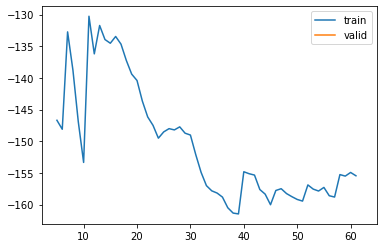

In [ ]:
spec_dls3, spec_learn3, spec_items3 = fine_tune2(var_learning3, spec_dls, spec_learn, spec_items)